<a href="https://mingxia.web.unc.edu/" target="_parent"><img src="https://mingxia.web.unc.edu/wp-content/uploads/sites/12411/2020/12/logo_MagicLab-horizontal-4.png" alt="MAGIC Lab"/></a>

# **MRI Segmentation PreTraining**
---

**Loading required libraries**
---

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
import sys, argparse
import enum
import time
import datetime
import random
import json
import multiprocessing
import os.path as osp
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pylab as pl
import logging
import shutil
import tempfile
from urllib.request import urlretrieve
import gzip
from PIL import Image

from pathlib import Path
from scipy import stats
from IPython import display
from tqdm import trange, tqdm
#from tqdm.notebook import tqdm

import copy
import pprint
import torchio as tio
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import L1Loss
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, roc_auc_score, matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.manifold import TSNE
from sklearn import svm
from neuroCombat import neuroCombat


import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset, ImageDataset
from monai.networks.nets import VarAutoEncoder,ViTAutoEnc, AutoEncoder
from monai.utils import set_determinism, first
from monai.utils.enums import MetricReduction
from monai.metrics import compute_hausdorff_distance, HausdorffDistanceMetric
from monai.losses import ContrastiveLoss, DiceLoss, DiceCELoss
from monai.transforms import (
    ConvertToMultiChannelBasedOnBratsClasses,
    AsDiscrete,
    Activations,

#    AddChannel,
#    Compose,
#    RandRotate90,
#    Resize,
#    ScaleIntensity,
#    EnsureType
    AddChannelD,
    Compose,
    LoadImageD,
    ScaleIntensityD,
    EnsureTypeD,
    LoadImaged,
    Compose,
    CropForegroundd,
    CopyItemsd,
    SpatialPadd,
    EnsureChannelFirstd,
    Spacingd,
    OneOf,
    ScaleIntensityRanged,
    RandSpatialCropSamplesd,
    RandCoarseDropoutd,
    RandCoarseShuffled
)

**Global Setting**
---

In [2]:
sns.set_style("whitegrid", {'axes.grid' : False})
#config InlineBackend.figure_format = 'retina'

torch.manual_seed(0)
set_determinism(seed=0)
pin_memory = torch.cuda.is_available()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


modelname = 'Pretext';
pretrained = True
downsampled = True
samplespace = 1
if downsampled:
    samplespace = 2 #2,4,8

pretrained_path = './pretrained/'
trained_path = './models/'
logdir_path = os.path.normpath('./log/')
if os.path.exists(logdir_path)==False:
    os.mkdir(logdir_path)
if os.path.exists(pretrained_path)==False:
    os.mkdir(pretrained_path)
if os.path.exists(trained_path)==False:
    os.mkdir(trained_path)    

if pretrained:
    savedir = trained_path+'Pretrained_'
else:
    savedir = trained_path

**File scanner**
---

In [3]:
class ScanFile(object):
    def __init__(self, directory, prefix=None, postfix=None):
        self.directory = directory
        self.prefix = prefix
        self.postfix = postfix

    def scan_files(self):
        files_list = []

        for dirpath, dirnames, filenames in os.walk(self.directory):
            ''''' 
            dirpath is a string, the path to the directory.   
            dirnames is a list of the names of the subdirectories in dirpath (excluding '.' and '..'). 
            filenames is a list of the names of the non-directory files in dirpath. 
            '''
            for special_file in filenames:
                if self.postfix:
                    if special_file.endswith(self.postfix):
                        files_list.append(os.path.join(dirpath, special_file))
                elif self.prefix:
                    if special_file.startswith(self.prefix):
                        files_list.append(os.path.join(dirpath, special_file))
                else:
                    files_list.append(os.path.join(dirpath, special_file))

        return files_list

    def scan_subdir(self):
        subdir_list = []
        for dirpath, dirnames, files in os.walk(self.directory):
            subdir_list.append(dirpath)
        return subdir_list

**Preparing for data reading**
---

In [4]:
images_dir = './data/ADNI/'
ADNI_dir   = './data/ADNI_linearRegRescale/'
#Ground truth of MRI reconstruction, not necessarily needed when using the inputs as supervsion.
scan1 = ScanFile(ADNI_dir, postfix='hpf.nii.gz')
#MRI scan after N3 bias correction, linear registration to template with size (181,217,181) and reslution 1*1*1, and image intensity rescaled to range (0,1), croped to (176,208,176).
scan2 = ScanFile(ADNI_dir, postfix='n3.nii.gz') 
#Corresponding MRI segmentation used as ground truth, have the same name with MRI scans but different postfix.
scan3 = ScanFile(ADNI_dir, postfix='-seg.nii.gz')
#Corresponding MRI ROIs parcellation, not used in this experiment.
scan4 = ScanFile(ADNI_dir, postfix='-roi.nii.gz')

ADNI_rec =  sorted(scan1.scan_files())
ADNI_mri  = sorted(scan2.scan_files()) 
ADNI_seg  = sorted(scan3.scan_files())
ADNI_roi  = sorted(scan4.scan_files())

data_list = []
for mri, rec, seg, roi in zip(ADNI_mri, ADNI_rec, ADNI_seg, ADNI_roi):
    data_list.append({
            "image": mri,
            "recon": rec,
            "seg": seg,
            "roi": roi
        })
train_Data = data_list[0:-200]
val_Data = data_list[-200:]

**Define Training Transforms**
---

In [7]:
class MDD_Dataset(torch.utils.data.Dataset):
    def __init__(self, images, recons, segs, rois, augment=False):
        subjects = []            
        for (image, recon, seg, roi) in zip(images, recons, segs, rois):
            subject = tio.Subject(
                mri=tio.ScalarImage(image),
                #rec=tio.ScalarImage(recon),
                seg=tio.LabelMap(seg),
                #roi=tio.LabelMap(roi),
                #labels=int(label),
            )
            subjects.append(subject)
        self.transform()
        if augment:
            self.dataset = tio.SubjectsDataset(subjects, transform=self.aug_transform)
        else:
            self.dataset = tio.SubjectsDataset(subjects, transform=self.preproc_transform)
            
    def transform(self):
        get_foreground = tio.ZNormalization.mean
        # From NiftyNet model zoo
        #LI_LANDMARKS = np.array([0, 8.06305571158, 15.5085721044, 18.7007018006, 21.5032879029, 26.1413278906, 29.9862059045, 33.8384058795, 38.1891334787, 40.7217966068, 44.0109152758, 58.3906435207, 100.0])
        ADNI_landmarks = np.array([0., 0., 0., 0., 0., 0., 0., 0., 1.64676642, 26.44374401, 47.65044424, 78.28128123, 100.])#ADNI_iBEAT
        landmarks_dict = {'mri': ADNI_landmarks}
        preprocess = tio.Compose([
            tio.ToCanonical(),
            #tio.CropOrPad((176, 208, 176)),                                              # tight crop around brain
            #tio.RescaleIntensity(percentiles=(0.,99.5), out_min_max=(0, 1.0)),
        ])
        augment = tio.Compose([
            tio.RandomAffine(scales=0.1,degrees=20,translation=5,isotropic=True,center='image'),       # random affine
        ])

        self.aug_transform = tio.Compose([preprocess, augment])
        self.preproc_transform = preprocess

In [8]:
from monai.networks.utils import one_hot
def get_loader(imagepaths,reconpaths,segpaths,roipaths, batch_size=1, augment=False):
    dataset = MDD_Dataset(images=imagepaths,recons=reconpaths,segs=segpaths,rois=roipaths, augment=augment)
    if augment:
        loader = DataLoader(dataset.dataset,batch_size=batch_size,num_workers=batch_size,shuffle=False,pin_memory=pin_memory,drop_last=False)
    else:
        loader = DataLoader(dataset.dataset,batch_size=batch_size,pin_memory=pin_memory)
    return loader

**Model Defination**
---

In [9]:
im_shape = (1,176,208,176)
model_AE3D_seg = AutoEncoder(
        spatial_dims=3,
        in_channels=1,
        out_channels=4,
        channels=(64,128,256,512),
        strides=(2,2,2,2),
        inter_channels=(512,512),
        inter_dilations=(1, 1),
        num_inter_units=2,
    )

test_number =  20
train_number = 100
train_loader = get_loader(ADNI_mri[0:train_number],ADNI_rec[0:train_number],ADNI_seg[0:train_number],ADNI_roi[0:train_number], batch_size=4, augment=True)
test_loader  = get_loader(ADNI_mri[-test_number:],ADNI_rec[-test_number:],ADNI_seg[-test_number:],ADNI_roi[-test_number:])

**Training Process Defination**
---

In [10]:
dice_loss = DiceLoss(include_background=True ,to_onehot_y=True, softmax=True)
HD95_loss = HausdorffDistanceMetric(include_background=False, distance_metric='euclidean', percentile=95, directed=False)

def train(model, max_epochs, learning_rate):
    model.to(device)
    avg_train_losses = []
    avg_train_dice_losses =[]
    avg_train_mse_losses = []
    avg_train_kld_losses = []
    test_losses = []
    t = trange(max_epochs, leave=True, desc="step: 0,  epoch: 0,   average train loss: ?, test loss: ?")
    
    for epoch in t:
        model.train()
        mse_losses = []
        dice_losses = []
        kld_losses = []
        epoch_losses = []
        epoch_loss = 0
        mse_loss = 0
        kld_loss = 0
        step = 0
        for batch_data in train_loader:
            step +=1
            inputs = batch_data['mri'][tio.DATA].to(device).float()
            target = batch_data['seg'][tio.DATA].to(device)

            optimizer.zero_grad()

            recon_batch = model(inputs)
            prob = torch.nn.functional.softmax(recon_batch, dim=1)
            seg = torch.argmax(prob, dim=1, keepdim=True)
            y = one_hot(target, num_classes=4, dim=1)
            y_pred  = one_hot(seg, num_classes=4, dim=1)
 
            dice = 10*dice_loss(recon_batch, target)#/train_loader.batch_size
            HD95 = torch.mean(HD95_loss(y_pred, y)) 
            loss = dice + HD95
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
        scheduler.step()
        avg_train_losses.append(np.mean(epoch_losses))

        if (epoch+1)%val_interval == 0:
            modelname = 'AE'+'_seg_diceCE'+'_epoch'+str(epoch+1)+'.pth'
            AE_model_name = savedir+modelname
            print(AE_model_name)
            torch.save(model.state_dict(), AE_model_name)
        t.set_description(f"step: {step}, epoch: {epoch + 1},   avg_train_losses: {avg_train_losses[-1]:.4f} ")
    return model, avg_train_losses, test_losses



**Model Training**
---

In [12]:

pretrained = False
max_epochs = 150
learning_rate = 1e-4
beta = 1.0
preAE_model = './models/Pretrained_AE_seg_epoch150.pth'
if pretrained:
    model_AE3D.load_state_dict(torch.load(preAE_model), strict = True)

model = model_AE3D_seg
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
model, avg_train_losses, test_losses = train(model, max_epochs, learning_rate)

modelname = 'AE'+'_seg_diceCE'+'_epoch'+str(max_epochs)
AE_model_name = savedir+modelname+'.pth'
print(AE_model_name)
torch.save(model.state_dict(), AE_model_name)
print("Training Finish!")

step: 0,  epoch: 0,   average train loss: ?, test loss: ?:   0%|          | 0/150 [00:29<?, ?it/s]


KeyboardInterrupt: 

**Test Process Defination**
---

In [12]:
def test(model):
    model.to(device)
    model.eval()
    test_losses = []
    test_mri_out= []

    test_seg_out = []
    test_recon_out = []
    test_loss = 0
    with torch.no_grad():
        for batch_data in tqdm(test_loader):            
            inputs = batch_data['mri'][tio.DATA].to(device).float()
            target = batch_data['seg'][tio.DATA].to(device)

            recon = model(inputs)
            test_mri_out.append(inputs.cpu())
            test_seg_out.append(target.cpu())

            prob = torch.nn.functional.softmax(recon, dim=1)
            seg = torch.argmax(prob, dim=1)
            test_recon_out.append(seg.cpu())
            #test_recon_out.append(recon.cpu())
            
            dice = dice_loss(recon, target)/test_loader.batch_size

            test_loss = dice
            test_losses.append(test_loss.cpu())
    print(f"test loss: {test_losses[-1]:.2f}")
    return test_losses, test_mri_out, test_seg_out, test_recon_out


pretrained = True
test_modelname = './models/'+modelname

if pretrained:
    modelname = 'Pretrained_AE_seg_diceHD95_epoch75'
    modelname = 'RecSeg_AE512_seg_dice_epoch16_loss8.07'
    test_modelname = './models/'+modelname
    model_AE3D_seg.load_state_dict(torch.load(test_modelname+'.pth'), strict = True)
    model = model_AE3D_seg
    
test_losses, test_mri_out, test_seg_out, recon_out = test(model)


  0%|          | 0/20 [00:00<?, ?it/s]

tensor(0.0670, device='cuda:0')
tensor(0.0704, device='cuda:0')
tensor(0.0702, device='cuda:0')
tensor(0.0686, device='cuda:0')
tensor(0.0686, device='cuda:0')
tensor(0.0664, device='cuda:0')
tensor(0.0673, device='cuda:0')
tensor(0.0655, device='cuda:0')
tensor(0.0704, device='cuda:0')
tensor(0.0666, device='cuda:0')
tensor(0.0665, device='cuda:0')
tensor(0.0657, device='cuda:0')
tensor(0.0657, device='cuda:0')
tensor(0.0680, device='cuda:0')
tensor(0.0639, device='cuda:0')
tensor(0.0647, device='cuda:0')
tensor(0.0701, device='cuda:0')
tensor(0.0701, device='cuda:0')
tensor(0.0695, device='cuda:0')
tensor(0.0642, device='cuda:0')
test loss: 0.06


**Results Vasualization**
---

torch.Size([1, 176, 208, 176])


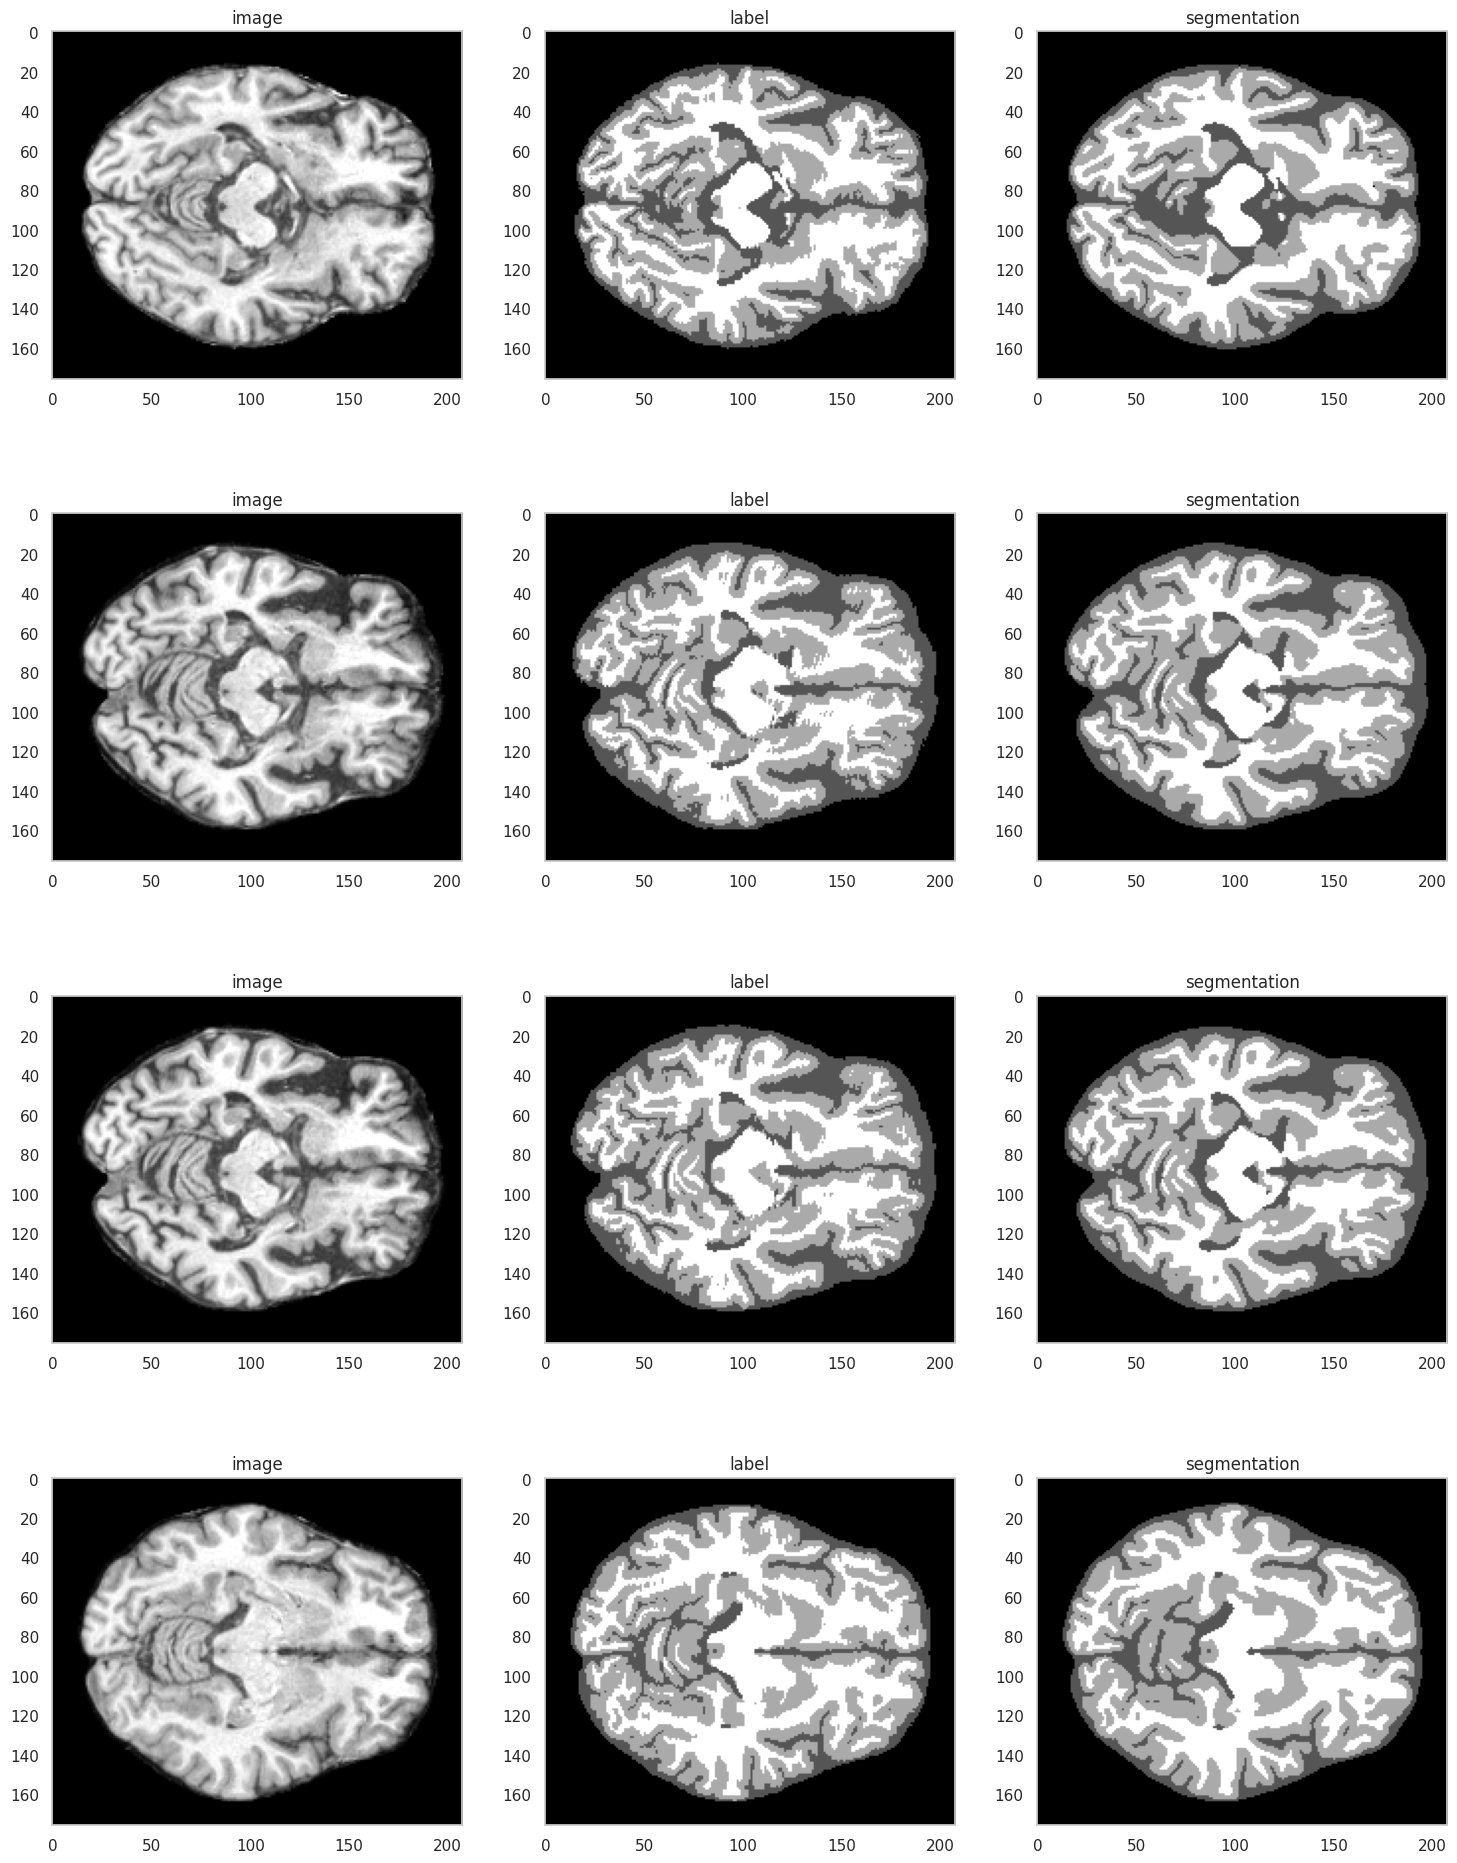

In [15]:
img = test_mri_out
#recon_out = test_seg_out
print(recon_out[0].shape)
slice_num = 58
show_size = 4
#out = one_hot(batch['seg'][tio.DATA], num_classes=4, dim=1)
#print(out.shape)
plt.figure("image", (18, 6*show_size))
for i in range(show_size):
    plt.subplot(show_size, 3, i*3+1)
    plt.title("image")
    #plt.imshow(img[0, :, :, slice_num], cmap="gray")
    plt.imshow(img[i][0,0,:, :, slice_num], cmap="gray")
    
    plt.subplot(show_size, 3, i*3+2)
    plt.title("label")
    plt.imshow(test_seg_out[i][0,0,:, :, slice_num], cmap="gray")
    
    plt.subplot(show_size, 3, i*3+3)
    plt.title("segmentation")
    #plt.imshow(recon_out[i][:, :, slice_num])
    plt.imshow(recon_out[i][0,:, :, slice_num], cmap="gray")
    
plt.savefig(test_modelname+'_slice'+str(slice_num)+'.jpg')    
plt.show()


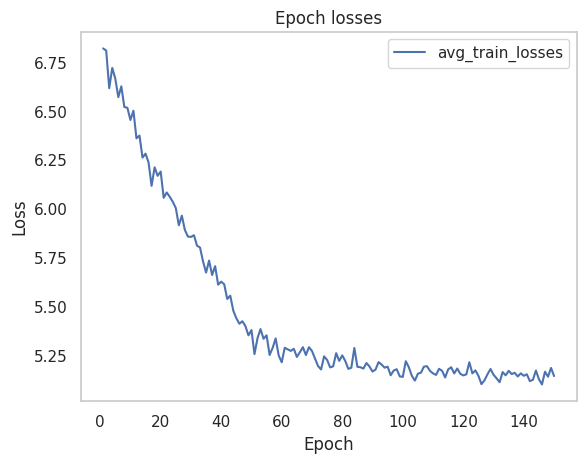

In [20]:
plt.figure()
plt.title("Epoch losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
#for y, label in zip([avg_train_kld_losses,avg_train_mse_losses], ['avg_train_kld_losses','avg_train_mse_losses']):
#for y, label in zip([avg_train_losses], ['avg_train_losses']):
for y, label in zip([avg_train_losses], ['avg_train_losses']):
#for y, label in zip([avg_train_kld_losses], ['avg_train_kld_losses']):
    x = list(range(1, len(y) + 1))
    line, = plt.plot(x, y)
    line.set_label(label)
plt.legend()